# Model.py Skeleton

In [1]:
import sys

sys.path

sys.executable

'/home/raymond/anaconda3/envs/keras/bin/python'

In [2]:
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

import keras
import keras.layers as layers

Using TensorFlow backend.


### Import Data

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2

<class 'numpy.ndarray'>
(160, 320, 3)


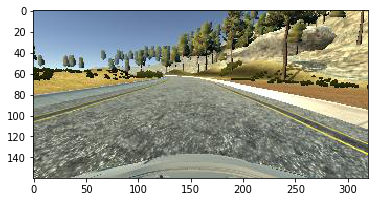

In [4]:
a = plt.imread('IMG/center_2019_09_01_11_19_10_669.jpg')
print(type(a))
print(a.shape)
plt.imshow(a)


In [5]:
from collections import deque

left_images = deque()
right_images = deque()
center_images = deque()

steering_angles = deque()

In [6]:
import csv

# [Center, left, right, steering, throttle, brake, speed]

with open('driving_log.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    print("Reading in CSV data ...", end="")
    for row in csv_reader:
        center_image_path = row[0]
        left_image_path = row[1]
        right_image_path = row[2]
        
        center_images.append(plt.imread(center_image_path))
        left_images.append(plt.imread(left_image_path))
        right_images.append(plt.imread(right_image_path))
        
        steering_angles.append(row[3])
    print(" Done")

Reading in CSV data ... Done


In [7]:
print(len(steering_angles))
print(len(left_images))

2194
2194


#### Combine Datasets

In [8]:
all_images = deque()
all_steering_angles = deque()

print("Combining Datasets ... ", end="")

for i in range(len(steering_angles)):
    
    all_images.append(center_images[i])
    all_images.append(left_images[i])
    all_images.append(right_images[i])
    
    for j in range(3):
        all_steering_angles.append(float(steering_angles[i]))
        

print("Done")

Combining Datasets ... Done


In [9]:
print(len(all_images))
print(len(all_steering_angles))

6582
6582


### Split Data

In [10]:
from sklearn.model_selection import train_test_split
train_dataset, valid_dataset, train_labels, valid_labels = train_test_split(all_images, \
                                                                            all_steering_angles, \
                                                                            test_size=0.2)

In [11]:
print(len(train_dataset))
print(len(train_labels))
print(len(valid_dataset))
print(len(valid_labels))

# print(valid_labels[0])
print(type(all_images))
print(type(train_dataset))

5265
5265
1317
1317
<class 'collections.deque'>
<class 'list'>


### Model

In [12]:
model = keras.Sequential()

In [15]:
from keras.layers import Dense, Activation, Dropout,Convolution2D,MaxPooling2D,Flatten,Lambda

model.add(Lambda(lambda x: x/127.5 - 1.0,input_shape=(160,320,3)))
model.add(layers.Cropping2D(cropping=((50,20), (0,0))))
# model.add(layers.Cropping2D(cropping=((50,20), (0,0)),input_shape=(160,320,3)))
model.add(Convolution2D(32, 8,8 ,border_mode='same', subsample=(4,4)))
model.add(Activation('relu'))
model.add(Convolution2D(64, 8,8 ,border_mode='same',subsample=(4,4)))
model.add(Activation('relu'))
model.add(Convolution2D(128, 4,4,border_mode='same',subsample=(2,2)))
model.add(Activation('relu'))
model.add(Convolution2D(128, 2,2,border_mode='same',subsample=(1,1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 80, 32)        6176      
_________________________________________________________________
activation_1 (Activation)    (None, 23, 80, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 20, 64)         131136    
_________________________________________________________________
activation_2 (Activation)    (None, 6, 20, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 10, 128)        131200    
__________

/home/raymond/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), strides=(4, 4), padding="same")`
  
/home/raymond/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (8, 8), strides=(4, 4), padding="same")`
  
/home/raymond/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (4, 4), strides=(2, 2), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/home/raymond/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (2, 2), strides=(1, 1), padding="same")`
  if sys.path[0] == '':


### Image Data Generator

In [17]:
from sklearn.utils import shuffle

# def crop_image(image):
#     crop_x = image.shape[1]
#     crop_y = crop.shape[0]
    
#     cropped_image = image[]


def randomize_translation(image):
    rows,cols,depth = image.shape

    # allow translation up to px pixels in x and y directions
    max_translation_pixels = int(rows/12)
    x_dist,y_dist = np.random.randint(-max_translation_pixels,max_translation_pixels,2)

    M = np.float32([[1,0,x_dist],[0,1,y_dist]])
    dst = cv2.warpAffine(image,M,(cols,rows))

    translated_image = dst[:,:,np.newaxis]

    return translated_image

def randomize_horizontal_flip(image, angle, thresh_angle=0.05):
#     if abs(angle) >= thresh_angle:
            
    #Flip image and steering angle every so often
    if np.random.randint(2) == 1:

        image = cv2.flip(image, 1)
        angle = -angle
        
    return image, angle
    

def train_generator_yield(X_dataset, y_labels, batch_size=64):  
    
    dataset_len = len(y_labels)
    
    while True:
    
        image_batch = deque()
        steering_batch = deque()
        
        X_dataset, y_labels = shuffle(X_dataset, y_labels)
    
        for i in range(batch_size):
            image = X_dataset[i]
            angle = y_labels[i]
            
            image, angle = randomize_horizontal_flip(image, angle)
            image = randomize_translation(image)
            
            image_batch.append(image)
            steering_batch.append(angle)

        
        image_batch = np.squeeze(np.asarray(image_batch))
        steering_batch = np.squeeze(np.asarray(steering_batch))


        yield [image_batch, steering_batch]
        

def valid_generator_yield(X_dataset, y_labels, batch_size=64):  
    
    dataset_len = len(y_labels)
    
    while True:
    
        image_batch = deque()
        steering_batch = deque()
        
        X_dataset, y_labels = shuffle(X_dataset, y_labels)
    
        for i in range(batch_size):
            image = X_dataset[i]
            angle = y_labels[i]
            
            image_batch.append(image)
            steering_batch.append(angle)
        
        image_batch = np.squeeze(np.asarray(image_batch))
        steering_batch = np.squeeze(np.asarray(steering_batch))


        yield [image_batch, steering_batch]
        
    


In [18]:
image_num = 1875
image, angle = randomize_horizontal_flip(all_images[image_num], all_steering_angles[image_num])

Original Steering Angle:  0.2478433
Flipped Steering Angle:  -0.2478433


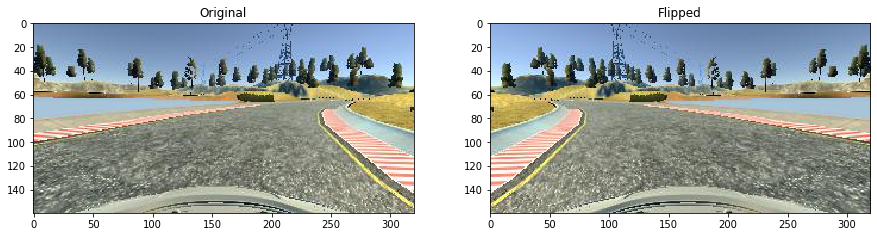

In [19]:
f, ax = plt.subplots(1, 2, figsize=(15,12))
ax[0].set_title("Original")
ax[0].imshow(all_images[image_num])
ax[1].set_title("Flipped")
ax[1].imshow(image)

print("Original Steering Angle: ", all_steering_angles[image_num])
print("Flipped Steering Angle: ", angle)
# plt.imshow(all_images[image_num])

### Training Parameters

In [20]:
EPOCHS = 20
BATCH_SIZE = 128

### Train Model

In [21]:
train_generator = train_generator_yield(train_dataset, train_labels, BATCH_SIZE)
valid_generator = train_generator_yield(valid_dataset, valid_labels, BATCH_SIZE)

# train_generator = train_generator_yield(all_images, all_steering_angles, BATCH_SIZE)

print(type(train_dataset))

<class 'list'>


In [22]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
# model.fit(X_train_gray,y_train,epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1)

In [23]:
model.fit_generator(train_generator, nb_epoch=2,\
                    steps_per_epoch=int(len(train_labels)/BATCH_SIZE), verbose=1, \
                    validation_data=valid_generator, validation_steps=len(valid_labels)/BATCH_SIZE)

/home/raymond/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/raymond/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=41, verbose=1, validation_data=<generator..., validation_steps=10.2890625, epochs=2)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/2
41/41 [==============================] - 29s 700ms/step - loss: 0.0098 - acc: 0.0347 - val_loss: 0.0054 - val_acc: 0.0462
Epoch 2/2
41/41 [==============================] - 27s 668ms/step - loss: 0.0040 - acc: 0.0366 - val_loss: 0.0020 - val_acc: 0.0462


In [24]:
model.save("model.h5")